In [1]:
!pip install --upgrade albumentations -q


import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
import glob
import shutil
import cv2

from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image  

import albumentations as A
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 38.2MB 76kB/s 
     |████████████████████████████████| 952kB 43.8MB/s 


In [ ]:
!unzip CarAccidentDataset.zip

In [9]:
def draw_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = stage + '_%s' % metric
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Value")
    plt.legend()
    filename = title + '.png'
    plt.show()

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, augmentation, image_size, label_to_id, shuffle=True):
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.image_size = image_size
        self.label_to_id = label_to_id

        self.image_names = np.array([item['path'] for item in data])
        self.targets = to_categorical(np.array([label_to_id[item['label']] for item in data]))
        self.samples = len(self.targets)

        self.indexes = np.arange(self.samples)
        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def transform_image(self, image):
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation = cv2.INTER_CUBIC)

        if self.augmentation:
            image = self.augmentation(image=image)['image']

        return image

    def __getitem__(self, index):
        take_ind = self.indexes[index * self.batch_size: min((index + 1) * self.batch_size, len(self.targets))]
        X = np.empty((len(take_ind), self.image_size, self.image_size, 3))
        y = self.targets[take_ind, :]

        for i in range(len(take_ind)):
            img = cv2.imread(self.image_names[take_ind[i]], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform_image(img)
            X[i] = img
            
        X = preprocess_input(X)

        return X, y

Create augmentations:

In [11]:
transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, 
                           p=0.5, border_mode=cv2.BORDER_CONSTANT), 
        A.RandomBrightnessContrast(p=0.5),
        A.RGBShift(p=0.25),
        A.GaussNoise(p=0.25),
        A.HorizontalFlip(p=0.5),
    ]
)

Create generators:

In [6]:
TRAIN_DIR = "/content/CarAccidentDataset"

In [23]:
INPUT_SHAPE = 96
BATCH_SIZE = 64
num_classes = 2

label_to_id = {
    'accident': 1,
    'normal': 0
}

In [24]:
train_data = []
label_stat = []

for label in os.listdir(TRAIN_DIR):
    for img_path in glob.glob(os.path.join(TRAIN_DIR, label, "*.jpg")):
        train_data.append({'path': img_path, 'label': label})
        label_stat.append(label)

train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=label_stat, shuffle=True)

train_generator = DataGenerator(train_data, BATCH_SIZE, transform, INPUT_SHAPE, label_to_id)
validation_generator = DataGenerator(val_data, BATCH_SIZE, None, INPUT_SHAPE, label_to_id, shuffle=False)

Build model:

In [25]:
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(INPUT_SHAPE, INPUT_SHAPE, 3))
for layer in model.layers:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

9412608/9406464 [==============================] - 0s 0us/step


Warmup:

In [26]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

Epoch 1/3
61/61 [==============================] - 40s 90ms/step - loss: 0.5474 - accuracy: 0.7219 - val_loss: 0.2558 - val_accuracy: 0.9125
Epoch 2/3
61/61 [==============================] - 5s 76ms/step - loss: 0.3318 - accuracy: 0.8535 - val_loss: 0.2275 - val_accuracy: 0.9104
Epoch 3/3
61/61 [==============================] - 5s 75ms/step - loss: 0.2920 - accuracy: 0.8797 - val_loss: 0.2053 - val_accuracy: 0.9219


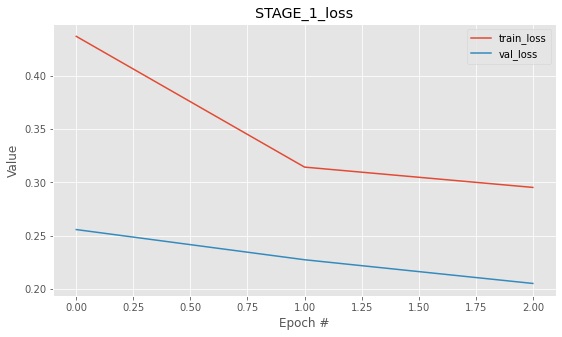

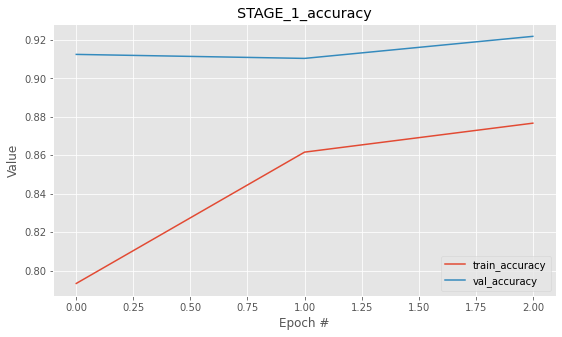

In [27]:
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS, verbose=1)

draw_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_1')
draw_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_1')

In [28]:
model.save("stage1.hdf5")

Unfreezeing deeper layers:

In [29]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0003
FINE_TUNE_FROM_LAYER = -20

In [30]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[FINE_TUNE_FROM_LAYER:]:
    if not isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = True

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
61/61 [==============================] - 8s 89ms/step - loss: 0.6151 - accuracy: 0.7162 - val_loss: 0.3483 - val_accuracy: 0.8323

Epoch 00001: val_loss improved from inf to 0.34833, saving model to model3_stage2.hdf5
Epoch 2/30
61/61 [==============================] - 5s 76ms/step - loss: 0.4171 - accuracy: 0.8115 - val_loss: 0.3504 - val_accuracy: 0.8469

Epoch 00002: val_loss did not improve from 0.34833
Epoch 3/30
61/61 [==============================] - 5s 76ms/step - loss: 0.3005 - accuracy: 0.8731 - val_loss: 0.3234 - val_accuracy: 0.8604

Epoch 00003: val_loss improved from 0.34833 to 0.32343, saving model to model3_stage2.hdf5
Epoch 4/30
61/61 [==============================] - 5s 77ms/step - loss: 0.2729 - accuracy: 0.8896 - val_loss: 0.1667 - val_accuracy: 0.9375

Epoch 00004: val_loss improved from 0.32343 to 0.16666, saving model to model3_stage2.hdf5
Epoch 5/30
61/61 [==============================] - 5s 79ms/step - loss: 0.2357 - accuracy: 0.9085 - val_loss: 0

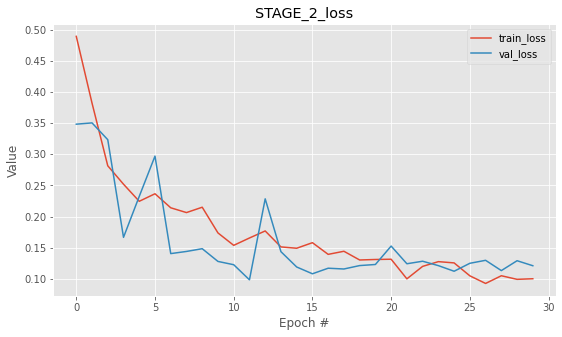

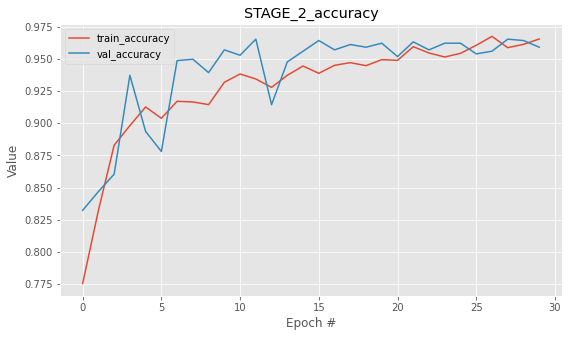

In [31]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=NUM_EPOCHS * train_generator.samples // BATCH_SIZE,
    end_learning_rate=LEARNING_RATE / 10,
    power=1.0)

opt = Adam(learning_rate=learning_rate_fn)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

save_best_checkpoint = ModelCheckpoint("model3_stage2.hdf5", verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    callbacks=[save_best_checkpoint], 
    verbose=1)

draw_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_2')
draw_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_2')

In [32]:
def save_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(21, 15))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = metric
    plt.title(title, fontsize=18)
    plt.xlabel("Epoch #", fontsize=18)
    plt.ylabel("Value", fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    filename = title + '.png'
    plt.savefig(filename)

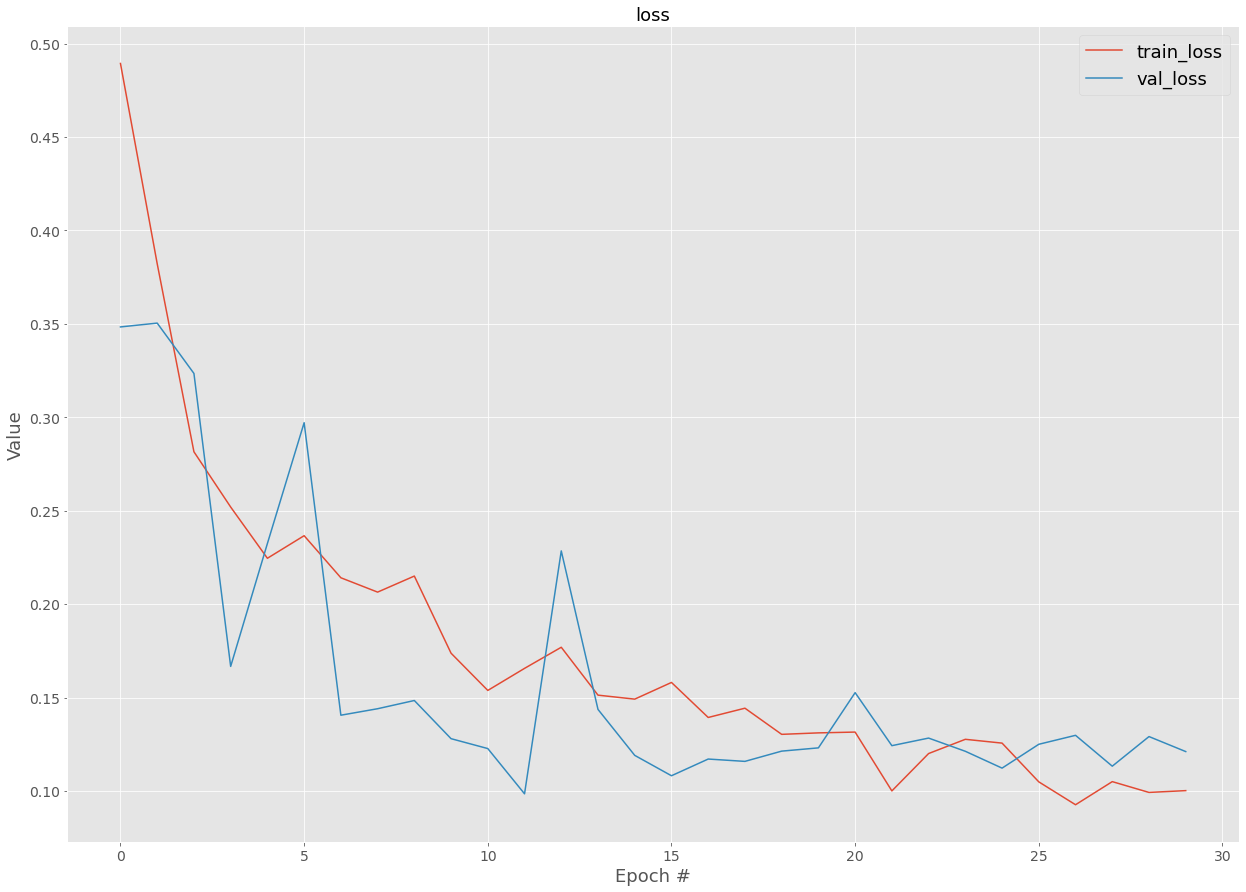

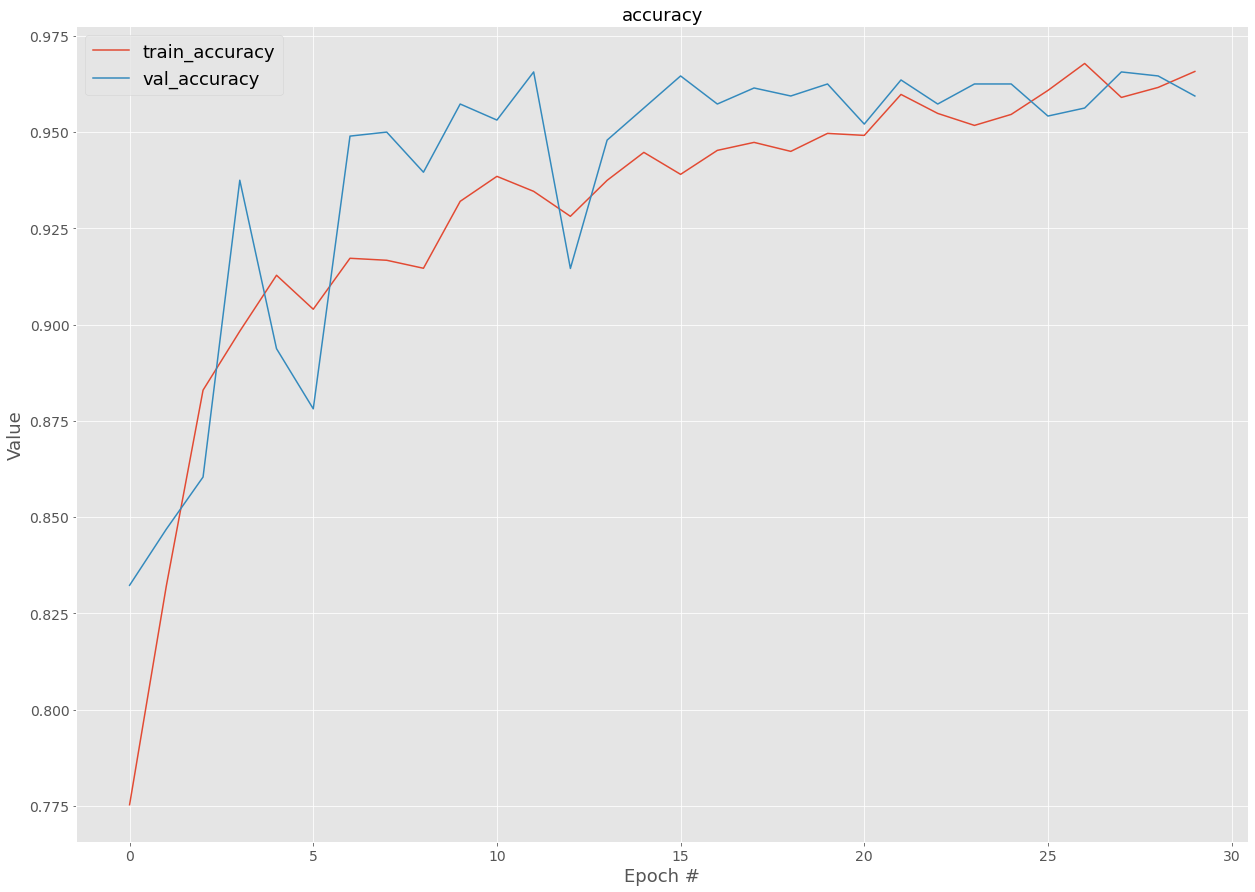

In [33]:
save_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_2')
save_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_2')